In this notebook, we use NQFS to study the ground state of the Calogero-Sutherland model:

\begin{equation}
H_{\text{CS}} = \ \frac{1}{2m} \int dx \frac{d\hat{\psi}^\dagger(x)}{dx} \frac{d \hat{\psi} (x)}{dx} 
+ \int dx \ (V(x)- \mu) \hat{\psi}^\dagger(x) \hat{\psi} (x) 
 + \frac{g \pi^2}{2 L^2} \int dx dy \ \hat{\psi}^\dagger(x) \hat{\psi}^\dagger(y) \hat{\psi}(y) \hat{\psi}(x) \Big[\sin(\tfrac{\pi}{L}(x-y))\Big]^{-2}.
\end{equation}

Below, we look at the system with no external potnetial ($V(x)=0$).

In [1]:
# Allow to import packages from NQFS Repo on Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Allow to import classes from ./modules
import sys
sys.path.insert(1, '/content/drive/My Drive/Research/NQFS Repo/modules')    # Set this directory to wherever the /modules folder is stored

Mounted at /content/drive


In [2]:
# Import packages
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from deep_sets import Deep_Sets
from nqfs_cs import NQFS_CS

In [3]:
# Creates NQFS


# NQFS parameters
DS_width = 100        # Width of the neural networks in the NQFS
DS_depth_phi = 3      # Depth of the phi neural network in the NQFS
DS_depth_rho = 3      # Depth of the rho neural network in the NQFS
L = 5                 # System length 
periodic = True       # System periodicity

# Creates NQFS for Calogero-Sutherland model
myNQFS = NQFS_CS(DS_width, DS_depth_phi, DS_depth_rho, L, periodic)

# Initializes GPU, moves NQFS to GPU
GPU_device = torch.device("cuda:0")
myNQFS.DS1.to(GPU_device)
myNQFS.DS2.to(GPU_device)
torch.set_default_dtype(torch.float32)

In [4]:
# Sets up Hamiltonian


# Hamiltonian parameters
m = 1/2                               # mass
g = 5                                 # CS interaction strength
lam = 1/2*(1 + (1 + 4*m*g)**0.5)      # lambda
a = np.pi**2*lam**2/(6*m*L**2)        # a term in the energy
mu = 3*5**2*a                         # chemical potential

def V(x):                             # external potential
  val = 0*x
  return val

def W(xy, g, L):                      # Calogero-Sutherland interaction potential
  val = g*np.pi**2/L**2*1/(torch.sin(np.pi*xy/L))**2
  return val

# Exact energy and particle number
E_exact = myNQFS.CS_energy(L, m, mu, g)
n_exact = myNQFS.CS_n(L, m, mu, g)
print('n_exact: ' + str(n_exact))
print('E_exact: ' + str(E_exact))

n_exact: 5
E_exact: -156.3173817581228


In [ ]:
# Minimize energy of NQFS


# MCMC parameters
n_samples = 800       # Number of samples per MCMC chain
n_chains = 100        # Number of independent MCMC chains
p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal

# Optimization parameters
beta_1 = 0.9          # ADAM parameter      
beta_2 = 0.999        # ADAM parameter
lr = 1e-3             # Learning rate
lr_q = 1e-1           # Learning rate for q_n
n_iters = 300         # Number of ADAM iterations to be performed

# Minimizes energy
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, 
                              m, mu, V, g, W, beta_1, beta_2, lr, lr_q, n_iters)

In [6]:
# OPTIONAL: Can also run the following staggered optimization, which switches 
# between optimizing over the neural networks and q_n parmareters (roughly, it
# optimizes over P_n and \varphi_n seperately), which can improve performance

p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal
lr = 1e-3             # Learning rate
lr_q = 0              # Learning rate for q_n
n_iters = 200         # Number of ADAM iterations to be performed
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, 
                              m, mu, V, g, W, beta_1, beta_2, lr, lr_q, n_iters)

p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal  
lr = 0                # Learning rate
lr_q = 5e-2           # Learning rate for q_n
n_iters = 200         # Number of ADAM iterations to be performed
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, 
                              m, mu, V, g, W, beta_1, beta_2, lr, lr_q, n_iters)
  
p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal  
lr = 1e-3             # Learning rate
lr_q = 5e-2           # Learning rate for q_n
n_iters = 100         # Number of ADAM iterations to be performed
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, 
                              m, mu, V, g, W, beta_1, beta_2, lr, lr_q, n_iters)

Iteration: 1/200
Energy: -59.75 +- 0.454
Number of particles: 1.404 +- 0.879


Iteration: 2/200
Energy: -64.114 +- 0.499
Number of particles: 1.528 +- 0.927


Iteration: 3/200
Energy: -68.19 +- 0.406
Number of particles: 1.637 +- 0.931


Iteration: 4/200
Energy: -70.388 +- 0.453
Number of particles: 1.692 +- 0.935


Iteration: 5/200
Energy: -74.791 +- 0.463
Number of particles: 1.815 +- 0.94


Iteration: 6/200
Energy: -77.281 +- 0.468
Number of particles: 1.887 +- 0.93


Iteration: 7/200
Energy: -80.216 +- 0.396
Number of particles: 1.96 +- 0.911


Iteration: 8/200
Energy: -80.514 +- 0.416
Number of particles: 1.967 +- 0.892


Iteration: 9/200
Energy: -81.529 +- 0.384
Number of particles: 1.99 +- 0.877


Iteration: 10/200
Energy: -82.134 +- 0.381
Number of particles: 2.006 +- 0.865


Iteration: 11/200
Energy: -82.074 +- 0.409
Number of particles: 2.002 +- 0.859


Iteration: 12/200
Energy: -82.131 +- 0.448
Number of particles: 2.015 +- 0.865


Iteration: 13/200
Energy: -81.936 +- 0.403


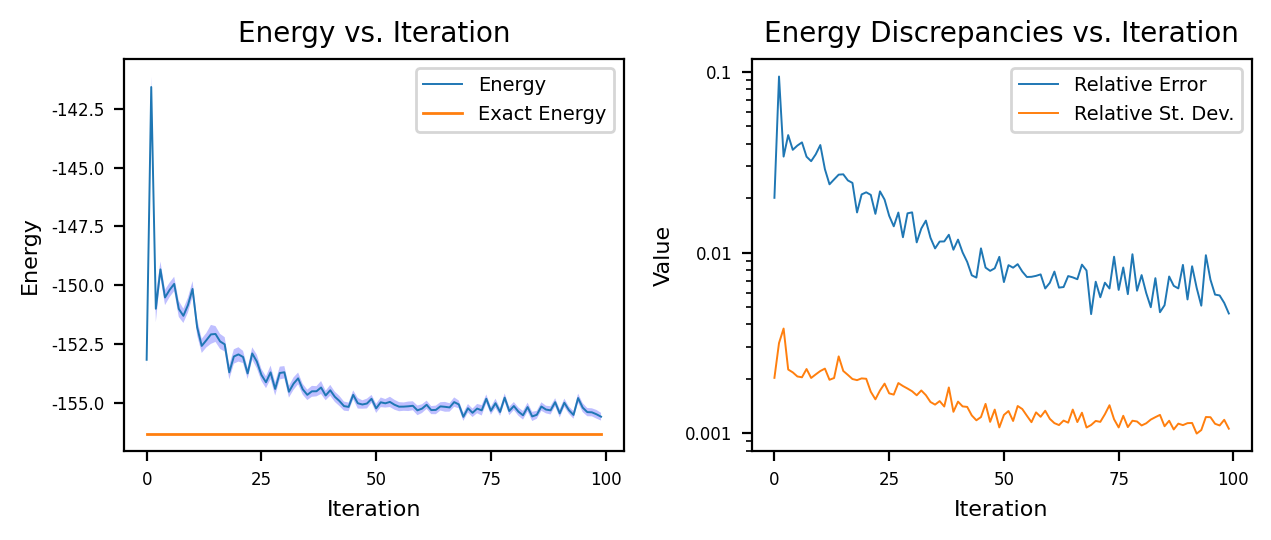

In [7]:
# Plots energy vs iteration
start = 0
end = n_iters
myNQFS.plot_energy(Es, E_stds, E_exact, start, end)

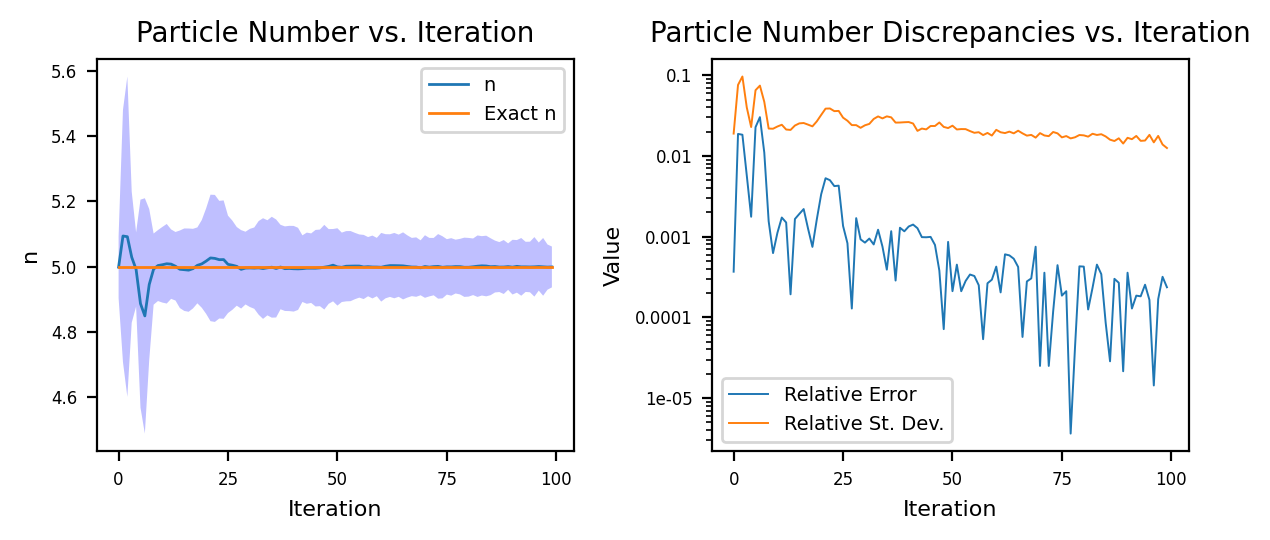

In [8]:
# Plots particle number vs iteration
start = 0
end = n_iters
myNQFS.plot_n(n_means, n_stds, n_exact, start, end)

In [9]:
# Estimate energy and particle number, uses repeated sampling to decrease variance

# MCMC parameters
n_samples = 1000                  # Number of samples per MCMC chain
n_chains = 100                    # Number of independent MCMC chains
p_pm = 0.05                       # Probability of increasing/decreasing particle number in configuration proposal
n_0 = round(n_means[-1].item())   # Initial particle number of each MCMC chain
N_reps = 5                        # Number of repetitions over which estimates are computed

Es_reps = np.zeros(N_reps)
E_stds_reps = np.zeros(N_reps)

# Use repeated sampling to decrease variance of estimates, estimates energy and 
# particle number over N_Reps repetitions
for j in range(N_reps):
  print('Repetition: ' + str(j+1) + '/' + str(N_reps))
  
  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
    myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                         GPU_device, m, g)

  # Concatenates particle numbers   
  if j == 0:
    n_total = n[None,:] 
  else:
    n_total = torch.cat((n_total, n[None,:]), dim=0)
    
  # Estimates energy, concatenates results    
  E, E_std = myNQFS.Energy_Estimate(x_sorted, chain_idx_sorted, n_chains, 
                                    GPU_device, m, mu, V, g, W)

  Es_reps[j-1] = E.detach().clone()
  E_stds_reps[j-1] = E_std.detach().clone()
    

# Computes final mean and standard deviation
E_mean_final = np.mean(Es_reps)
E_std_final = (np.mean(E_stds_reps**2)/N_reps)**(0.5)

n_total = n_total.cpu().numpy().astype(float)
n_mean_final = np.mean(n_total)
n_std_final = np.std(n_total)

print('\n')
print("Energy: " + str(E_mean_final) + " +- " + str(E_std_final))
print("Number of particles: " + str(n_mean_final) + " +- " + str(n_std_final))

Repetition: 1/5
Repetition: 2/5
Repetition: 3/5
Repetition: 4/5
Repetition: 5/5


Energy: -155.465283203125 +- 0.05283565109501472
Number of particles: 4.999142857142857 +- 0.07062461847467834


In [10]:
# Estimate one-body density matrix of NQFS

# MCMC parameters
n_samples = 1000                  # Number of samples per MCMC chain
n_chains = 100                    # Number of independent MCMC chains
p_pm = 0.05                        # Probability of increasing/decreasing particle number in configuration proposal
n_0 = round(n_means[-1].item())   # Initial particle number of each MCMC chain

# Energy density parameters
N_pts = 40          # Number of points at which the one-body density matrix is estimated over [0,L]
N_reps = 5         # Number of repetitions over which estimates are computed

one_bodies = np.zeros(N_pts)
one_bodies_var = np.zeros(N_pts)

# Use repeated sampling to decrease variance
for j in range(N_reps):
  print('\n \n' + 'Repetition: ' + str(j+1) +'/' + str(N_reps))
  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
  myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                       GPU_device, m, g)

  # Evaluate one-body density matrix
  one_bodies_tmp, one_bodies_std_tmp = myNQFS.OneBody_function(N_pts, x_sorted, 
                               chain_idx_sorted, n_chains, GPU_device, m, g) 

  one_bodies += one_bodies_tmp
  one_bodies_var = one_bodies_std_tmp**2

one_bodies *= 1/N_reps
one_bodies_std = (one_bodies_var**0.5)/N_reps


 
Repetition: 1/5
Evaluating one-body density matrix at point 1/40
Evaluating one-body density matrix at point 2/40
Evaluating one-body density matrix at point 3/40
Evaluating one-body density matrix at point 4/40
Evaluating one-body density matrix at point 5/40
Evaluating one-body density matrix at point 6/40
Evaluating one-body density matrix at point 7/40
Evaluating one-body density matrix at point 8/40
Evaluating one-body density matrix at point 9/40
Evaluating one-body density matrix at point 10/40
Evaluating one-body density matrix at point 11/40
Evaluating one-body density matrix at point 12/40
Evaluating one-body density matrix at point 13/40
Evaluating one-body density matrix at point 14/40
Evaluating one-body density matrix at point 15/40
Evaluating one-body density matrix at point 16/40
Evaluating one-body density matrix at point 17/40
Evaluating one-body density matrix at point 18/40
Evaluating one-body density matrix at point 19/40
Evaluating one-body density matrix at po

In [11]:
# Evaluate exact one-body density matrix

# Create exact ground state
myNQFS_exact = NQFS_CS(DS_width, DS_depth_phi, DS_depth_rho, L, periodic)
myNQFS_exact.DS1.to(GPU_device)
myNQFS_exact.DS2.to(GPU_device)
myNQFS_exact.exact = True

# MCMC parameters
n_samples = 1200                  # Number of samples per MCMC chain
n_chains = 100                    # Number of independent MCMC chains
p_pm = 0.00                       # Probability of increasing/decreasing particle number in configuration proposal
n_0 = n_exact                     # Initial particle number of each MCMC chain

# Energy density parameters
N_pts = 40           # Number of points at which the one-body density matrix is estimated over [0,L]
N_reps = 5            # Number of repetitions over which estimates are computed

one_bodies_exact = np.zeros(N_pts)
one_bodies_exact_var = np.zeros(N_pts)

# Use repeated sampling to decrease variance
for j in range(N_reps):
  print('\n \n' + 'Repetition: ' + str(j+1) +'/' + str(N_reps))
  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
  myNQFS_exact.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                       GPU_device, m, g)

  # Evaluate one-body density matrix
  one_bodies_exact_tmp, one_bodies_exact_std_tmp = myNQFS_exact.OneBody_function(N_pts, x_sorted, 
                               chain_idx_sorted, n_chains, GPU_device, m, g) 

  one_bodies_exact += one_bodies_exact_tmp
  one_bodies_exact_var += one_bodies_exact_std_tmp**2

one_bodies_exact *= 1/N_reps
one_bodies_exact_std = (one_bodies_exact_var**0.5)/N_reps


 
Repetition: 1/5
Evaluating one-body density matrix at point 1/40
Evaluating one-body density matrix at point 2/40
Evaluating one-body density matrix at point 3/40
Evaluating one-body density matrix at point 4/40
Evaluating one-body density matrix at point 5/40
Evaluating one-body density matrix at point 6/40
Evaluating one-body density matrix at point 7/40
Evaluating one-body density matrix at point 8/40
Evaluating one-body density matrix at point 9/40
Evaluating one-body density matrix at point 10/40
Evaluating one-body density matrix at point 11/40
Evaluating one-body density matrix at point 12/40
Evaluating one-body density matrix at point 13/40
Evaluating one-body density matrix at point 14/40
Evaluating one-body density matrix at point 15/40
Evaluating one-body density matrix at point 16/40
Evaluating one-body density matrix at point 17/40
Evaluating one-body density matrix at point 18/40
Evaluating one-body density matrix at point 19/40
Evaluating one-body density matrix at po

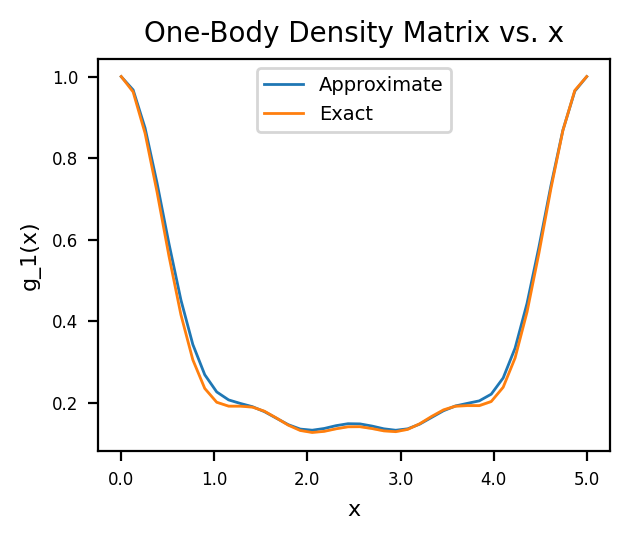

In [12]:
# Plot one-body density matrix
myNQFS_exact.plot_one_body(one_bodies, one_bodies_std, one_bodies_exact, 
                           one_bodies_exact_std)